In [32]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import pandas_datareader as pdr

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import yfinance as yf
from tqdm.autonotebook import tqdm
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster 

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters, EfficientFCParameters
from sklearn.decomposition import PCA
from dtaidistance import clustering, dtw

# Создаем функцию для получение данных о котировках криптокоинов

In [33]:
def get_info(ticker_obj):
    info_keys = ['shortName']
    info_values = []
    for key in info_keys:
        info_values.append(ticker_obj.info.get(key, None))
    return dict(zip(info_keys, info_values))

Скачиваем данные

In [34]:
interesting_tickers = ['BTC-USD','ETH-USD', 'BNB-USD', 'ADA-USD', 'DOGE-USD', 'SHIB-USD', 'LTC-USD', 'ETC-USD', 
           'BCH-USD', 'VET-USD', 'FIL-USD', 'SNX-USD', 'KAVA-USD', 'TWT-USD', 'KSM-USD', 'YFI-USD',
          'UTK-USD', 'RPL-USD', 'SOL-USD', '1INCH-USD', 'THETA-USD', 'OCEAN-USD', 'CHR-USD', 'WRX-USD',
          'DENT-USD', 'DNT-USD', 'CRV-USD', 'DOT-USD', 'KEY-USD', 'BEAM-USD', 'MATIC-USD', 'HEX-USD',
           'AAVE-USD', 'EGLD-USD', 'BTT-USD', 'CAKE-USD', 'HNT-USD', 'DASH-USD', 'ZIL-USD','XDC-USD',
           'KSM-USD','CEL-USD', 'QTUM-USD', 'GLM-USD', 'WAXP-USD', 'NFLX-USD', 'QNT-USD', 'AAPL-USD',
          'NVDA-USD', 'GOOGL-USD']
load = False

if load:
    full_ticker_data = []
    for ticker in tqdm(interesting_tickers):  #tqdm - помогает понять, сколько уже сделано (визуальная стркоа загрузки)
        try:
            ticker_obj = yf.Ticker(ticker)
            close_price = ticker_obj.history(period='1y', interval='1d')['Close'].to_dict()
            info = get_info(ticker_obj)
            info.update(close_price)
            full_ticker_data.append(info)
        except Exception as e:
            print(e)
            continue
        
    full_ticker_df_0 = pd.DataFrame(full_ticker_data)
    full_ticker_df = pd.DataFrame(full_ticker_df_0.iloc[:,1:].pct_change(axis='columns'))
    full_ticker_df.insert(0, "shortName", full_ticker_df_0.shortName)
    full_ticker_df.to_csv("C:/ЦМФ/Project-1. Algo-belikova-zvegincev/full_ticker_df_month_01_2022.csv")

else: 
    full_ticker_df = pd.read_csv("C:/ЦМФ/Project-1. Algo-belikova-zvegincev/full_ticker_df_month_01_2022.csv", index_col=0)
    datetime_columns = pd.to_datetime(full_ticker_df.columns[5:])
    full_ticker_df.columns = list(full_ticker_df.columns[:5]) + list(datetime_columns)

Смотрим на наши данные(общая структура и размерность), проверяем пропущенные значение

In [35]:
#full_ticker_df.isnull().sum(axis=1)
full_ticker_df.shape

(50, 367)

In [36]:
#full_ticker_df.drop('2021-10-06 00:00:00', axis=1, inplace=True)
full_ticker_df.head()

,shortName,2021-10-06 00:00:00,2021-10-07 00:00:00,2021-10-08 00:00:00,2021-10-09 00:00:00,2021-10-10 00:00:00,2021-10-11 00:00:00,2021-10-12 00:00:00,2021-10-13 00:00:00,2021-10-14 00:00:00,...,2022-09-27 00:00:00,2022-09-28 00:00:00,2022-09-29 00:00:00,2022-09-30 00:00:00,2022-10-01 00:00:00,2022-10-02 00:00:00,2022-10-03 00:00:00,2022-10-04 00:00:00,2022-10-05 00:00:00,2022-10-06 00:00:00
0,Bitcoin USD,NaN,-0.028097,0.003008,0.018536,-0.003577,0.049537,-0.025115,0.024269,-0.001386,...,-0.005833,0.016544,0.007532,-0.007217,-0.006160,-0.013877,0.030428,0.036347,-0.008660,-0.004657
1,Ethereum USD,NaN,0.002070,-0.006749,0.003355,-0.041912,0.034882,-0.014887,0.032534,0.049862,...,-0.003889,0.005476,-0.001315,-0.005745,-0.012300,-0.027104,0.037102,0.029232,-0.006820,0.009101
2,BNB USD,NaN,0.007718,-0.044807,0.005840,-0.039094,0.020705,0.073554,0.060564,0.002704,...,-0.012780,0.034433,0.007125,0.001421,-0.004646,0.005519,0.009137,0.032284,-0.007293,-0.000922
3,Cardano USD,NaN,0.029311,-0.017488,0.013159,-0.030619,-0.010843,-0.024938,0.032967,-0.008538,...,-0.010894,-0.010410,0.002012,-0.008572,-0.009486,-0.024774,0.019934,0.018147,-0.010308,-0.003912
4,Dogecoin USD,NaN,-0.047861,0.003820,0.011257,-0.068091,0.007389,-0.022725,0.027979,-0.001286,...,-0.007857,0.000231,0.001732,0.015232,-0.016642,-0.022086,0.018486,0.092375,-0.018602,-0.003851


## Заполняем данные по ценам за последнюю дату (сейчас NA - Так как данных за текущий день еще нет)

In [37]:
full_ticker_df = full_ticker_df.iloc[:, :-1]
prices = full_ticker_df.iloc[:, 5:].T
prices = prices.fillna(method='backfill')
prices = prices.fillna(method='ffill')
full_ticker_df = full_ticker_df.iloc[:, :5].join(prices.T)

In [38]:
scaler = StandardScaler()
tickers_scaled = scaler.fit_transform(full_ticker_df.iloc[:, 5:].T).T

# Фичи-экстракторы

#Подготавливаем данный для работы с фичами, для этого создаем фрейм из данных по нашим индексам по каждому дню только теперь уже отскалированных значений

In [39]:
tickers_scaled_2_df = pd.DataFrame(tickers_scaled, index=full_ticker_df.shortName, columns=full_ticker_df.iloc[:,:-5].columns).drop(columns='shortName')
tickers_scaled_2_df.head()

,2021-10-06 00:00:00,2021-10-07 00:00:00,2021-10-08 00:00:00,2021-10-09 00:00:00,2021-10-10 00:00:00,2021-10-11 00:00:00,2021-10-12 00:00:00,2021-10-13 00:00:00,2021-10-14 00:00:00,2021-10-15 00:00:00,...,2022-09-21 00:00:00,2022-09-22 00:00:00,2022-09-23 00:00:00,2022-09-24 00:00:00,2022-09-25 00:00:00,2022-09-26 00:00:00,2022-09-27 00:00:00,2022-09-28 00:00:00,2022-09-29 00:00:00,2022-09-30 00:00:00
shortName,,,,,,,,,,,,,,,,,,,,,
Bitcoin USD,1.517292,-0.672519,0.776083,0.023531,2.250562,-0.270017,0.382831,0.289349,1.121614,0.854273,...,0.720345,-0.106906,0.549505,0.285149,-0.147510,-0.116490,-0.342859,0.956758,1.130394,-0.189848
Ethereum USD,0.826881,-0.297973,0.773816,1.165445,0.495900,-0.150220,0.137170,-0.539261,0.815581,1.660840,...,0.756300,-0.049388,0.162254,0.008781,-0.091352,-0.239498,-0.574087,0.877053,0.699190,-0.115637
BNB USD,0.551642,1.941979,1.600231,0.078070,0.100591,-0.440688,0.288478,0.816675,0.171688,0.700624,...,0.186124,-0.329262,0.912804,0.194399,0.044328,-0.115282,0.152139,0.247319,0.856257,-0.184908
Cardano USD,-0.152609,-0.440983,0.743761,-0.105442,0.486759,-0.272011,-0.125704,-0.202993,-0.077850,0.776009,...,0.095339,-0.153648,-0.143740,0.110421,-0.106138,-0.124846,-0.437633,0.477106,0.440547,-0.141663
Dogecoin USD,0.202115,-0.413289,0.622884,0.024845,0.183881,0.357940,0.103307,0.857125,-0.072266,0.741623,...,0.030066,-0.109452,0.055839,0.086512,0.362391,-0.288962,-0.400220,0.428893,1.938869,-0.329017


#Зададим наши фич-экстракторы с разным количеством метрик, затем посмотрим на результат и выберем ту которая, более точно распределит наши активы по кластерам

In [40]:
data=[]
for i in range(50):
    for j in range(360):
        data.append(tickers_scaled_2_df.iloc[i,j])
data = pd.DataFrame(data)
#df_000 = pd.DataFrame([i for i in range(360)])
data['index_coin'] = np.repeat(range(50), 360)
#data
extraction_settings_Comprehensive = ComprehensiveFCParameters()
extraction_settings_Minimal = MinimalFCParameters()
extraction_settings_Efficient = EfficientFCParameters()


X_Comprehensive = extract_features(data, column_id='index_coin', impute_function=impute,
                    default_fc_parameters=extraction_settings_Comprehensive)
X_Minimal = extract_features(data, column_id='index_coin', impute_function=impute,
                    default_fc_parameters=extraction_settings_Minimal)
X_Efficient = extract_features(data, column_id='index_coin', impute_function=impute,
                    default_fc_parameters=extraction_settings_Efficient)


Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Удаляем те индексы, в которых есть пропущенные значения (то есть эти индексы нам не нужны, и лишь будут затруднять и портить
наше распределение по кластерам!

In [41]:
X_Comprehensive = X_Comprehensive.dropna(axis=1)
X_Minimal = X_Minimal.dropna(axis=1)
X_Efficient = X_Efficient.dropna(axis=1)

# Визуализируем для каждого набора фичей распределение активов по кластерам. Опять конечно же будем смотреть на метрику silhouette (так как он дает более точный ответ на вопрос о кол-ве класторов по сравнению с правилом локтя)

  0%|          | 0/28 [00:00<?, ?it/s]

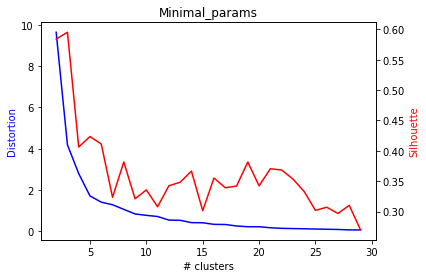

  0%|          | 0/28 [00:00<?, ?it/s]

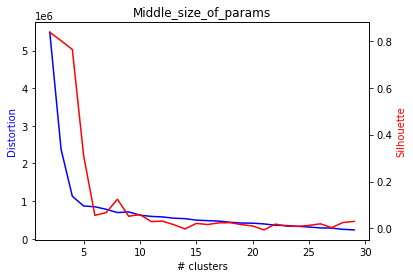

  0%|          | 0/28 [00:00<?, ?it/s]

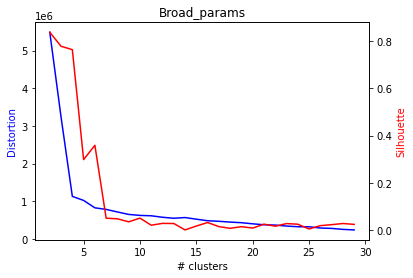

In [42]:
distortions = []
silhouette = []
K = range(2,30)
for feature_matrix, type_ in zip([X_Minimal, X_Efficient, X_Comprehensive], ['Minimal_params', 'Middle_size_of_params', 'Broad_params']):
    distortions = []
    silhouette = []
    for k in tqdm(K):
        kmeanModel = TimeSeriesKMeans(n_clusters=k)
        kmeanModel.fit(feature_matrix)
        distortions.append(kmeanModel.inertia_)
        silhouette.append(silhouette_score(feature_matrix, kmeanModel.labels_, metric="euclidean"))
        
    fig, ax1 = plt.subplots()
       
    plt.title(type_)
    ax2 = ax1.twinx()
    ax1.plot(K, distortions, 'b-')
    ax2.plot(K, silhouette, 'r-')
        
    ax1.set_xlabel('# clusters')
    ax1.set_ylabel('Distortion', color='b')
    ax2.set_ylabel('Silhouette', color='r')
      
    plt.show()  #Правило локтя - помогает определить какое кол-во кластеров нужно и возможно сделать.

#Подготавливаем данные для визуализации (предсказывая кластеры для активов с помощью каждого набора и распределяя их в каждый отдельный фрейм (в последствии, если добавить все в один фрейм визуализация ниже испортится, из-за лишних столбцов в общем фрейме) (p.s. под лишними столбцами понимается предсказанные для каждого набора фичей кластеры активов))

In [43]:
n_clusters = [3,6,5]

ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters[0], metric="euclidean", n_jobs=6, max_iter=10)
ts_kmeans.fit(X_Minimal)
full_ticker_df_1 = full_ticker_df
full_ticker_df_1['cluster_min_feature'] = ts_kmeans.predict(X_Minimal)

ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters[1], metric="euclidean", n_jobs=6, max_iter=10)
ts_kmeans.fit(X_Efficient)
full_ticker_df_2 = full_ticker_df.drop(columns='cluster_min_feature')
full_ticker_df_2['cluster_mid_feature'] = ts_kmeans.predict(X_Efficient)

ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters[2], metric="euclidean", n_jobs=6, max_iter=10)
ts_kmeans.fit(X_Comprehensive)
full_ticker_df_3 = full_ticker_df.drop(columns=['cluster_min_feature'])
full_ticker_df_3['cluster_broad_feature'] = ts_kmeans.predict(X_Comprehensive)

In [44]:
def plot_cluster_tickers(current_cluster):
    fig, ax = plt.subplots(
        int(np.ceil(current_cluster.shape[0]/4)),
        4,
        figsize=(15, 3*int(np.ceil(current_cluster.shape[0]/4)))
    )
    fig.autofmt_xdate(rotation=45)
    ax = ax.reshape(-1)

    for index, (_, row) in enumerate(current_cluster.iterrows()):
        ax[index].plot(row.iloc[5:-1])
        ax[index].set_title(f"{row.shortName}")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

#Визуализируем наше итоговое распределение по кластерам по каждому типу фичей

                          Cluster name: cluster_min_feature
                          Cluster number: 0


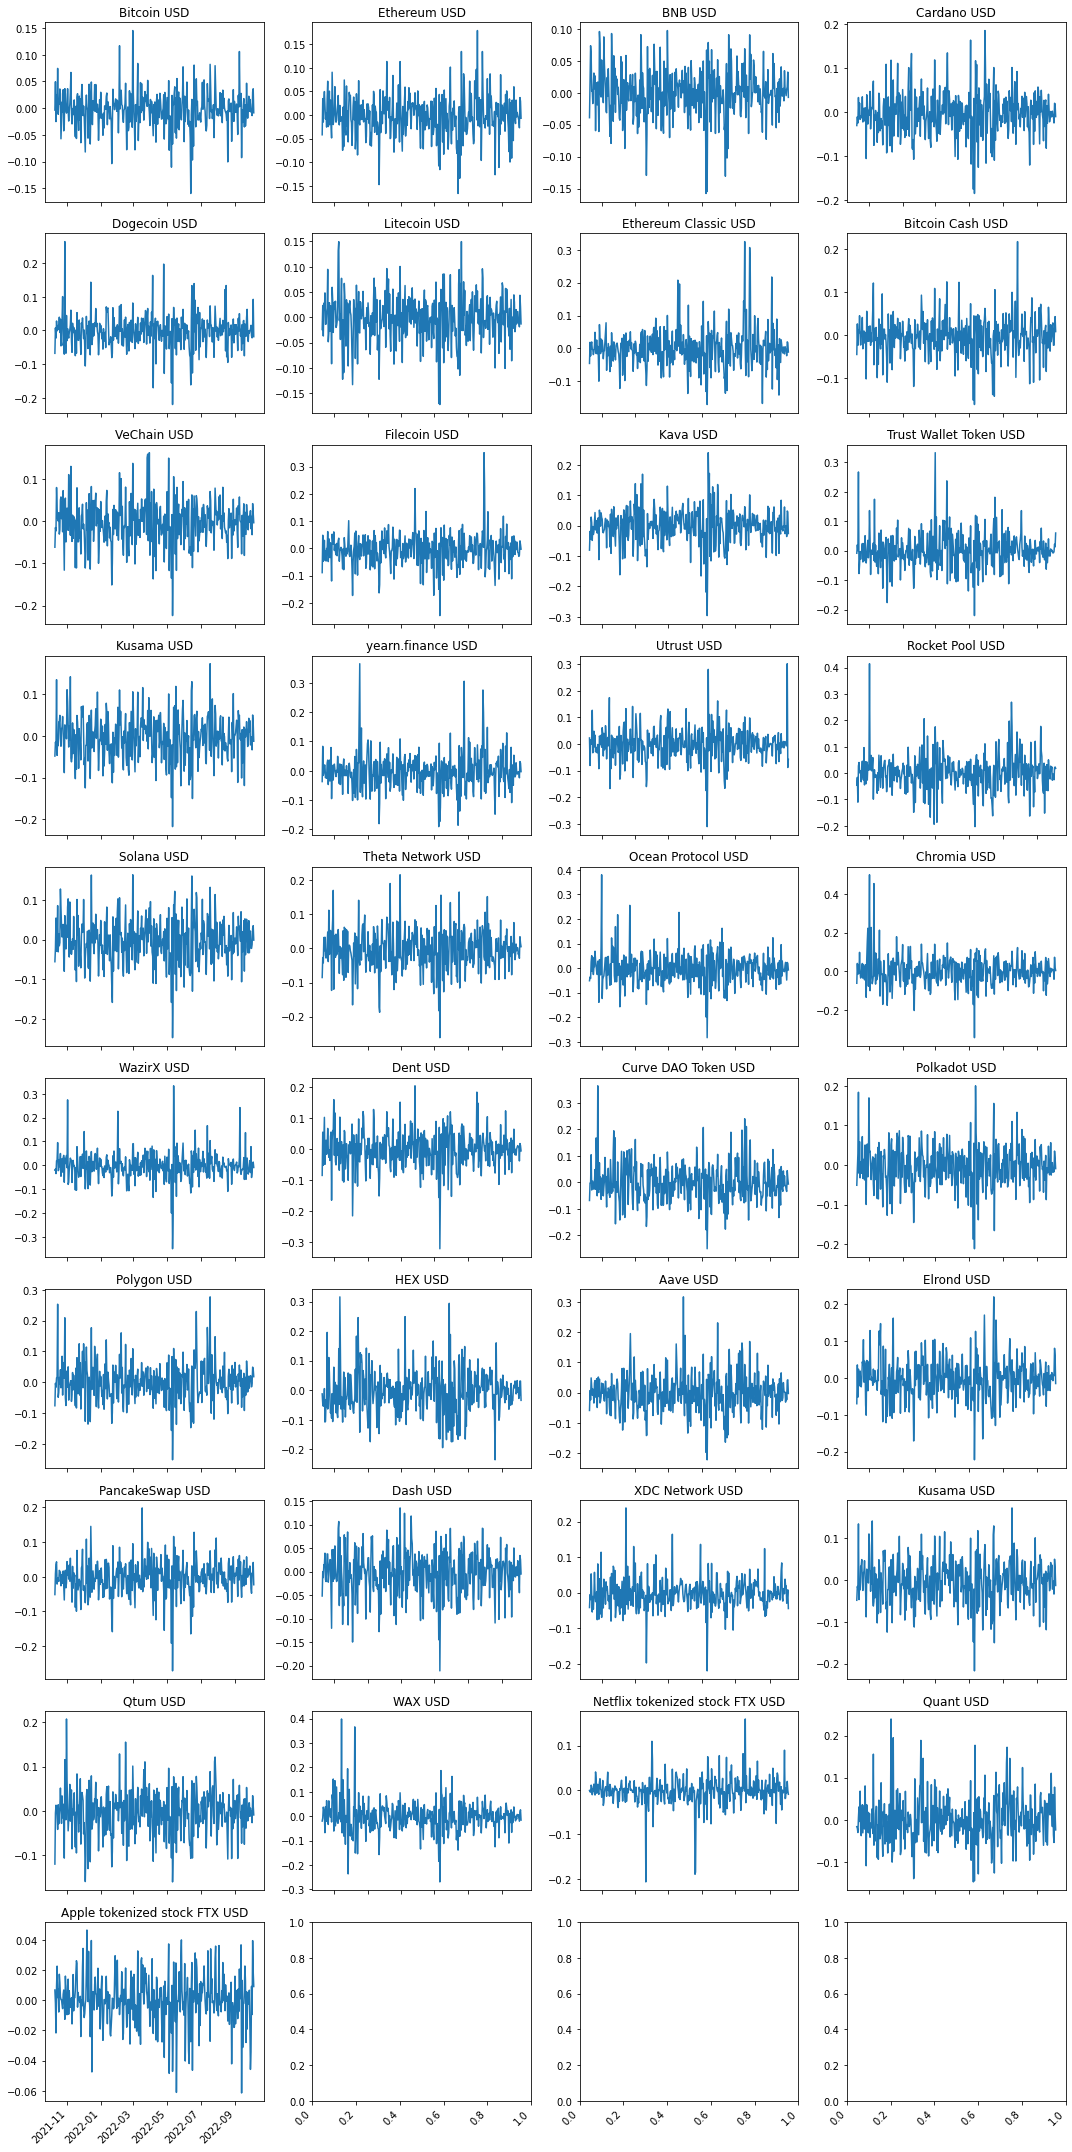

                          Cluster name: cluster_min_feature
                          Cluster number: 1


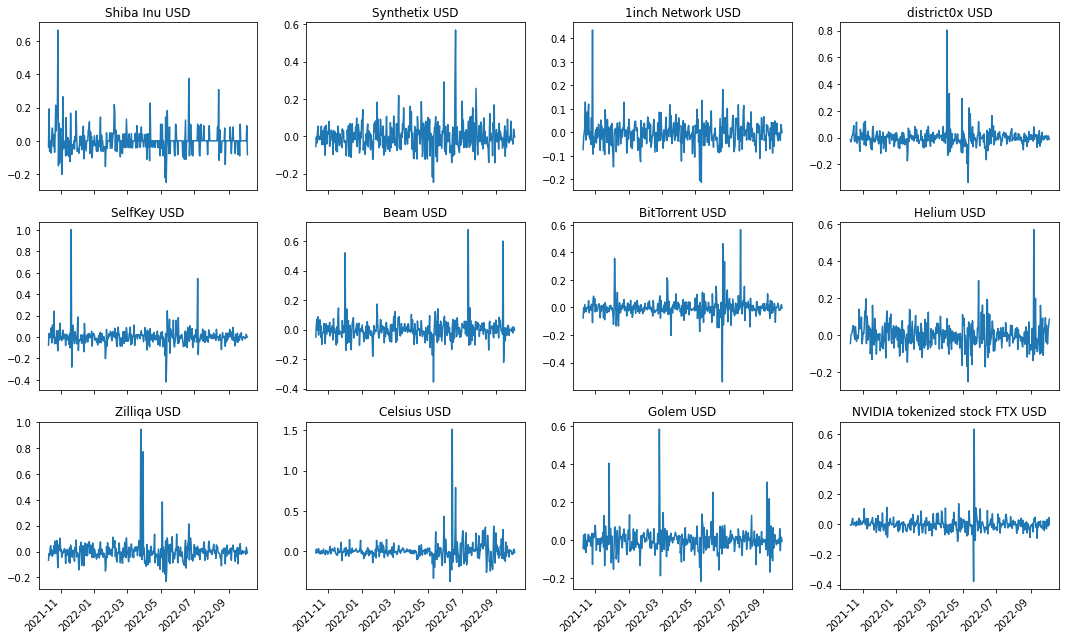

                          Cluster name: cluster_min_feature
                          Cluster number: 2


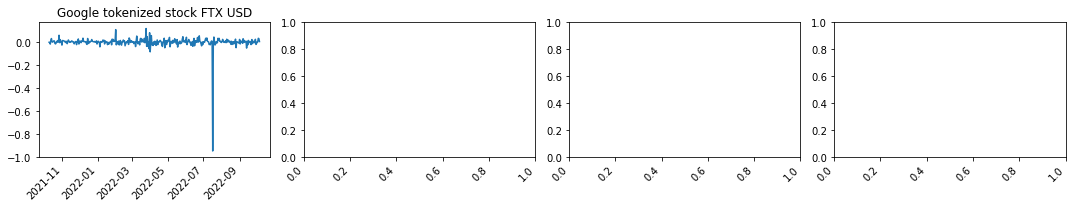

                          Cluster name: cluster_mid_feature
                          Cluster number: 0


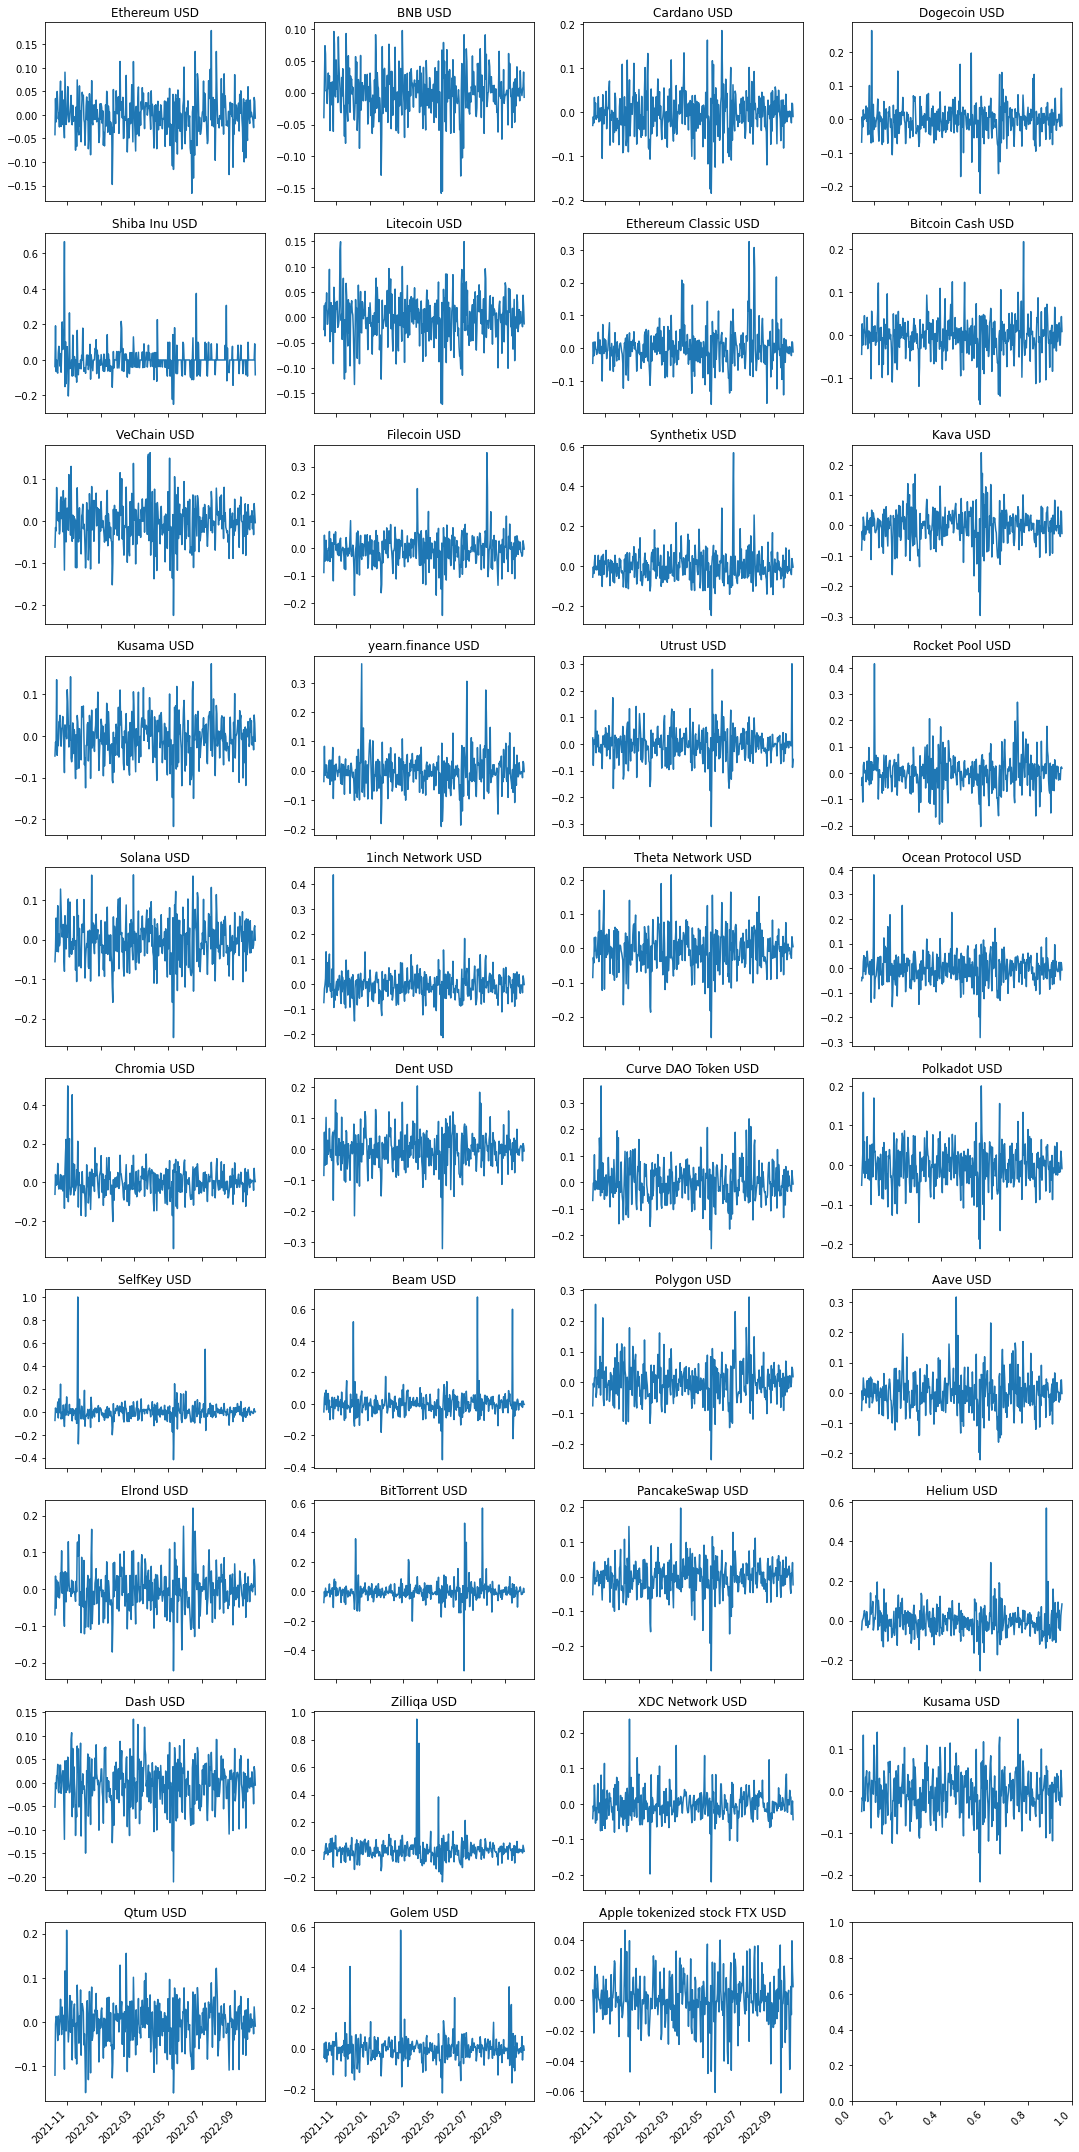

                          Cluster name: cluster_mid_feature
                          Cluster number: 1


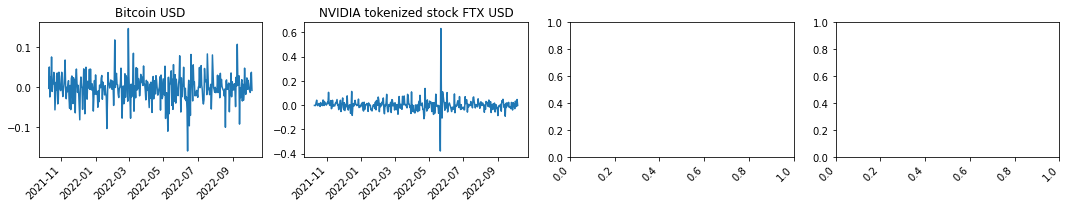

                          Cluster name: cluster_mid_feature
                          Cluster number: 2


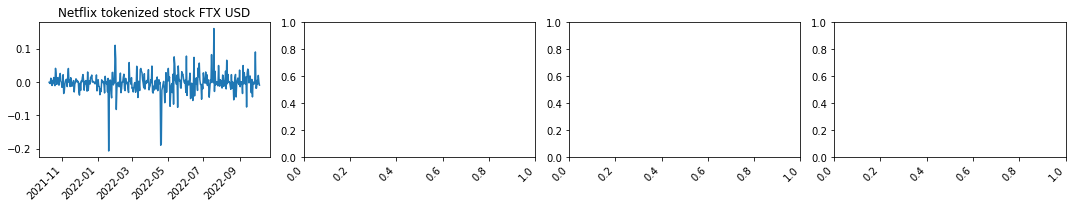

                          Cluster name: cluster_mid_feature
                          Cluster number: 3


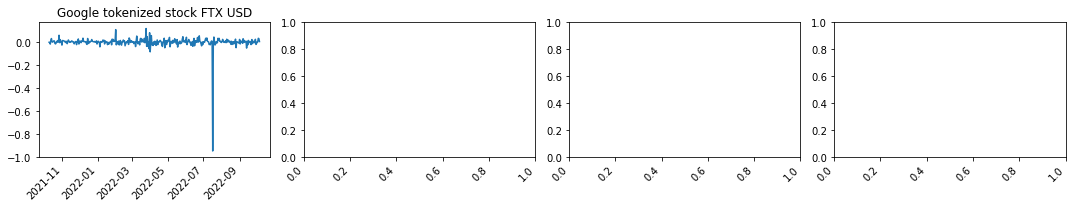

                          Cluster name: cluster_mid_feature
                          Cluster number: 4


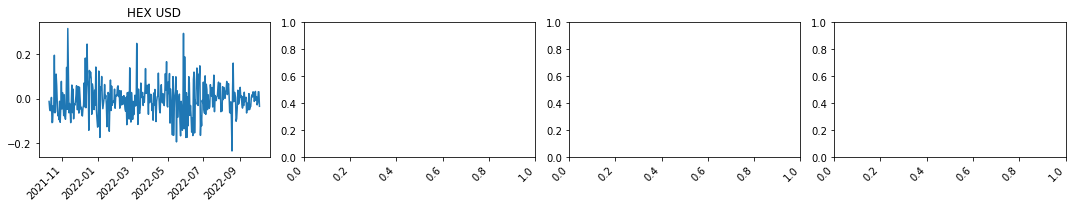

                          Cluster name: cluster_mid_feature
                          Cluster number: 5


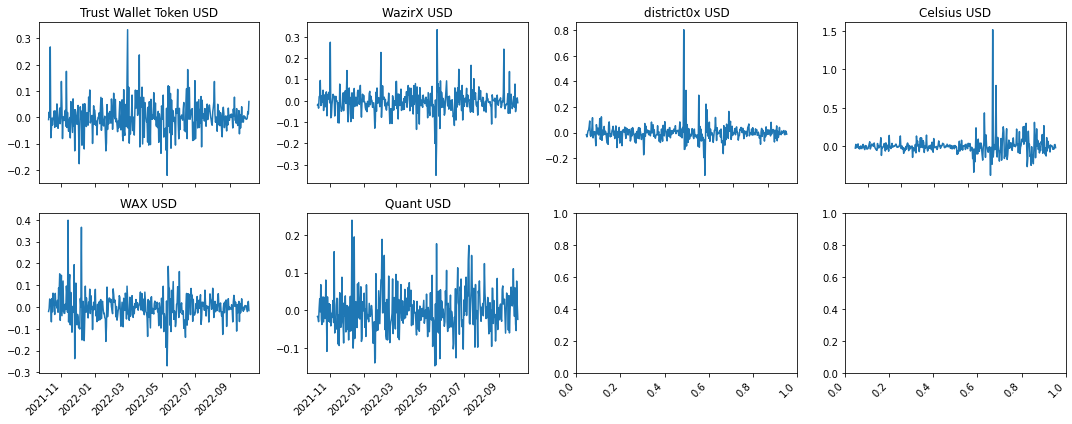

                          Cluster name: cluster_broad_feature
                          Cluster number: 0


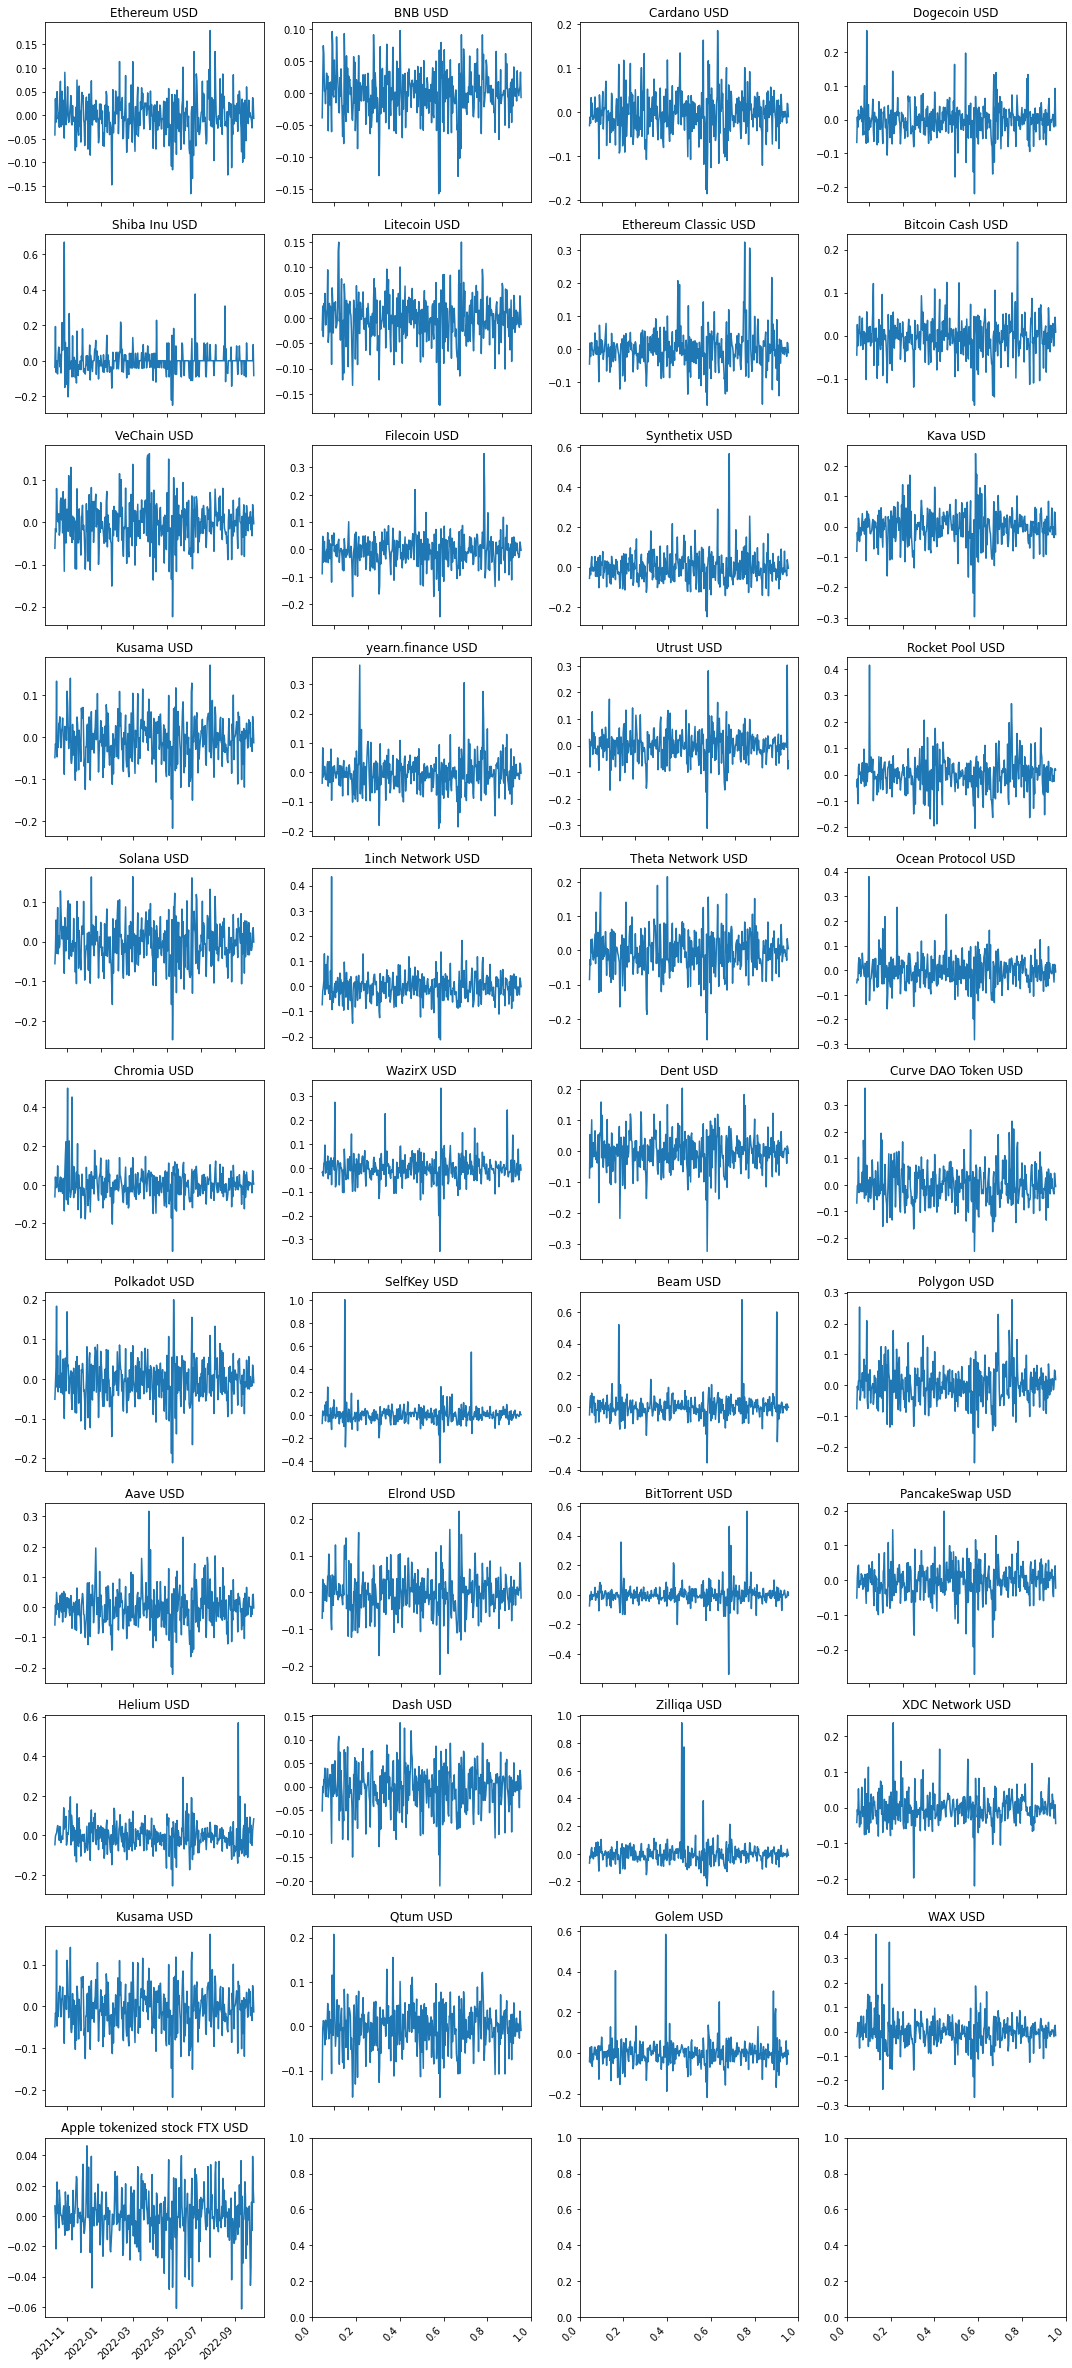

                          Cluster name: cluster_broad_feature
                          Cluster number: 1


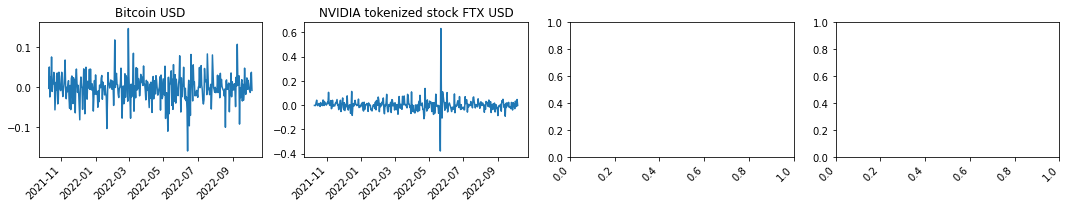

                          Cluster name: cluster_broad_feature
                          Cluster number: 2


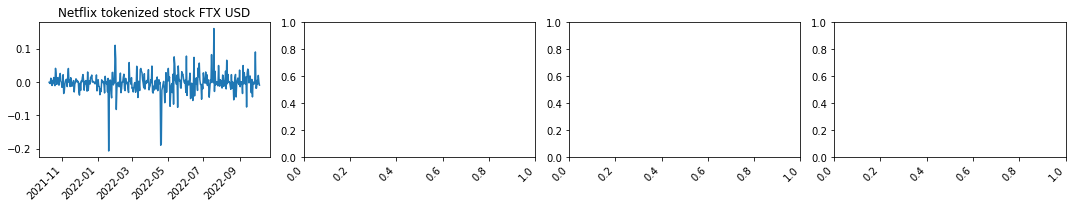

                          Cluster name: cluster_broad_feature
                          Cluster number: 3


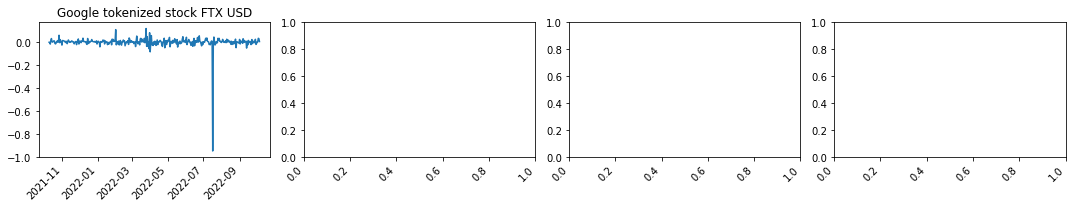

                          Cluster name: cluster_broad_feature
                          Cluster number: 4


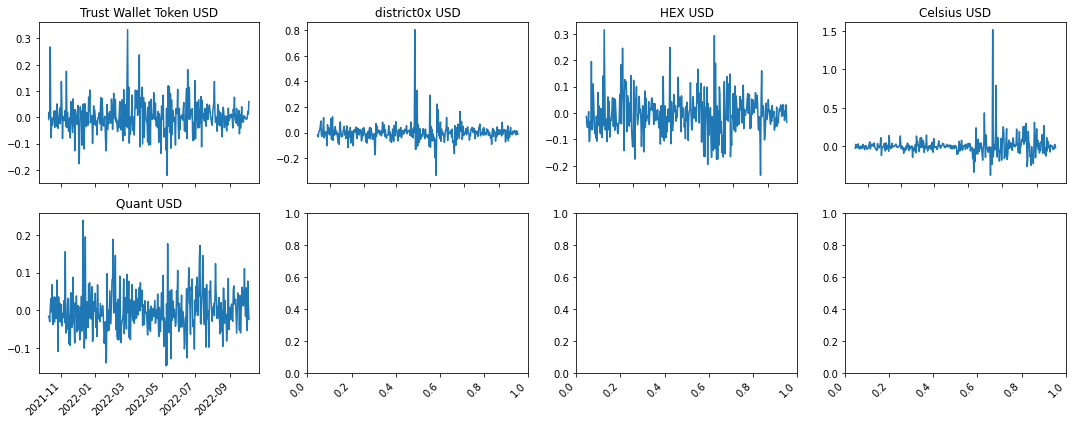

In [45]:
figsize = (10,10)
i=0
for dframe, name in zip([full_ticker_df_1, full_ticker_df_2, full_ticker_df_3], ['cluster_min_feature','cluster_mid_feature', 'cluster_broad_feature']):
    
    for cluster in range(n_clusters[i]):
        print(f"                          Cluster name: {name}")
        print("=================================================================================")
        print(f"                          Cluster number: {cluster}")
        print("=================================================================================")
        plot_cluster_tickers(dframe[dframe[name]==cluster])
    print("=================================================================================")
    print("=================================================================================")
    print("=================================================================================")
    i=i+1


# Визуализация на примере Tsfel (применяем другой фич-экстрактор и смотрим как рабоатет он)

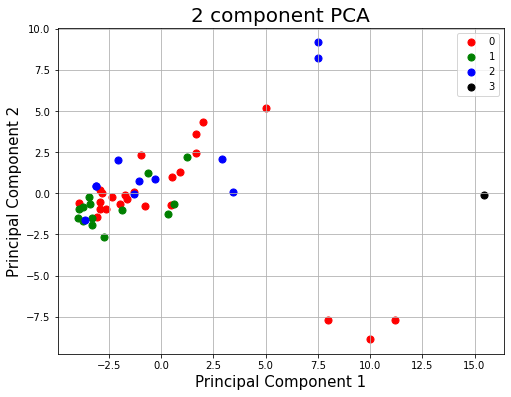

In [46]:
kmeanModel_tsfel = TimeSeriesKMeans(n_clusters=4)
kmeanModel_tsfel.fit(tickers_scaled)
clusters_tsfel = kmeanModel_tsfel.predict(tickers_scaled)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(tickers_scaled)
principalDf = pd.DataFrame(data = X_pca , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, pd.DataFrame(clusters_tsfel, columns=['Cluster'])], axis = 1)
finalDf.head(3)
def plot_pca(finalDf):
    fig = plt.figure(figsize = (8,6))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    targets = [0, 1, 2, 3]
    colors = ['r', 'g', 'b', 'k']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf['Cluster'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                  , finalDf.loc[indicesToKeep, 'principal component 2']
                  , c = color
                  , s = 50)
    ax.legend(targets)
    ax.grid()
plot_pca(finalDf)

# Визуализируем лучший результат kMeans с фич-экстрактором extraction_settings_Minimal

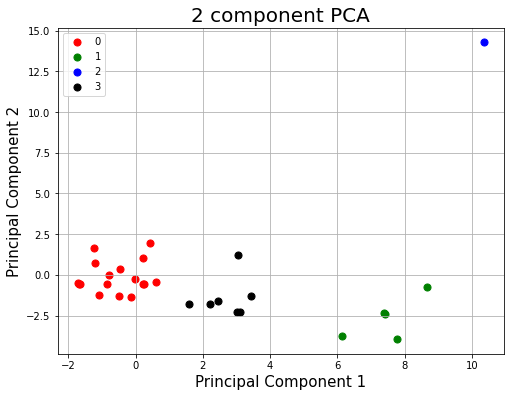

In [47]:
ts_kmeans.fit(X_Minimal)
clusters_ts_X_feature_Min = ts_kmeans.predict(X_Minimal)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_Minimal)
principalDf = pd.DataFrame(data = X_pca , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, pd.DataFrame(clusters_ts_X_feature_Min, columns=['Cluster'])], axis = 1)
finalDf.head(3)
def plot_pca(finalDf):
    fig = plt.figure(figsize = (8,6))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    targets = [0, 1, 2, 3]
    colors = ['r', 'g', 'b', 'k']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf['Cluster'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                  , finalDf.loc[indicesToKeep, 'principal component 2']
                  , c = color
                  , s = 50)
    ax.legend(targets)
    ax.grid()
plot_pca(finalDf)

# Итоги

Невооруженным взглядом видно, что фич-экстрактор tsfresh различает кластеры лучше, чем tsfell. Причем оказалось, что для текущего набора индексов(активов) будет лучшим фичом минимальным набор метрик: получили более детальное и точное распределение на 4 кластера.

Берем уже скаченную нами базу данных и используем метод linkage с метриками евклидового расстояния, чтобы распределить наши тикеры по кластерам (использую Иераррхическую кластеризацию)

# Базовый DTW

#Используем уже имеющиеся у нас данные, строим силуэт и локоть, только теперь метрикой у нас будет служить не евклидово растояние (как было ранее), а dtw

In [51]:
full_ticker_df_2_0 = full_ticker_df.drop(columns='cluster_min_feature')
full_ticker_df_2_0

,shortName,2021-10-06 00:00:00,2021-10-07 00:00:00,2021-10-08 00:00:00,2021-10-09 00:00:00,2021-10-10 00:00:00,2021-10-11 00:00:00,2021-10-12 00:00:00,2021-10-13 00:00:00,2021-10-14 00:00:00,...,2022-09-26 00:00:00,2022-09-27 00:00:00,2022-09-28 00:00:00,2022-09-29 00:00:00,2022-09-30 00:00:00,2022-10-01 00:00:00,2022-10-02 00:00:00,2022-10-03 00:00:00,2022-10-04 00:00:00,2022-10-05 00:00:00
0,Bitcoin USD,NaN,-0.028097,0.003008,0.018536,-0.003577,0.049537,-0.025115,0.024269,-0.001386,...,0.022368,-0.005833,0.016544,0.007532,-0.007217,-0.006160,-0.013877,0.030428,0.036347,-0.008660
1,Ethereum USD,NaN,0.002070,-0.006749,0.003355,-0.041912,0.034882,-0.014887,0.032534,0.049862,...,0.031759,-0.003889,0.005476,-0.001315,-0.005745,-0.012300,-0.027104,0.037102,0.029232,-0.006820
2,BNB USD,NaN,0.007718,-0.044807,0.005840,-0.039094,0.020705,0.073554,0.060564,0.002704,...,0.006811,-0.012780,0.034433,0.007125,0.001421,-0.004646,0.005519,0.009137,0.032284,-0.007293
3,Cardano USD,NaN,0.029311,-0.017488,0.013159,-0.030619,-0.010843,-0.024938,0.032967,-0.008538,...,0.001275,-0.010894,-0.010410,0.002012,-0.008572,-0.009486,-0.024774,0.019934,0.018147,-0.010308
4,Dogecoin USD,NaN,-0.047861,0.003820,0.011257,-0.068091,0.007389,-0.022725,0.027979,-0.001286,...,-0.001030,-0.007857,0.000231,0.001732,0.015232,-0.016642,-0.022086,0.018486,0.092375,-0.018602
5,Shiba Inu USD,NaN,-0.178571,0.173913,0.000000,-0.037037,0.192308,-0.064516,0.000000,-0.068966,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,-0.083333
6,Litecoin USD,NaN,0.000370,-0.015659,0.020948,-0.024157,0.023429,-0.036942,0.027955,0.014018,...,0.015201,-0.013004,0.010830,0.011361,-0.009590,-0.009180,-0.018811,0.043624,0.020715,-0.013005
7,Ethereum Classic USD,NaN,-0.010732,-0.011858,0.035923,-0.045873,0.018449,-0.022969,0.011557,0.019633,...,0.004158,-0.010527,-0.016841,0.004982,-0.002951,-0.006455,-0.022395,0.019876,0.017330,-0.011164
8,Bitcoin Cash USD,NaN,-0.010641,-0.026765,0.031406,-0.045308,0.025856,-0.023864,0.012016,0.005228,...,0.023811,-0.015450,-0.001267,0.021686,0.028269,-0.023801,-0.023717,0.016225,0.042882,0.008027
9,VeChain USD,NaN,-0.005636,-0.001468,0.059627,-0.061434,-0.014714,-0.022702,0.080606,0.030465,...,0.012577,-0.002290,0.010463,0.025384,-0.017470,0.011839,-0.031673,0.042358,0.017367,-0.003089


  0%|          | 0/28 [00:00<?, ?it/s]

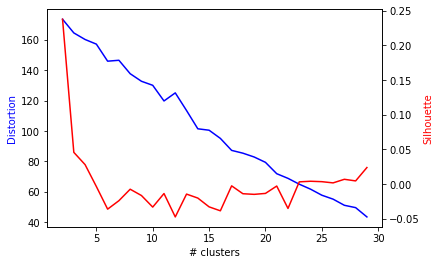

In [52]:
distortions = []
silhouette = []
K = range(2,30)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k)
    kmeanModel.fit(tickers_scaled)
    distortions.append(kmeanModel.inertia_)
    silhouette.append(silhouette_score(tickers_scaled, kmeanModel.labels_, metric="dtw"))

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(K, distortions, 'b-')
ax2.plot(K, silhouette, 'r-')

ax1.set_xlabel('# clusters')
ax1.set_ylabel('Distortion', color='b')
ax2.set_ylabel('Silhouette', color='r')

plt.show()  #Правило локтя - помогает определить какое кол-во кластеров нужно и возможно сделать.

#Выделяем всего 2 класетра, согласно метрике силуэта

In [53]:
n_clusters = 2
ts_kmeans = TimeSeriesKMeans(n_clusters = n_clusters, metric = 'dtw', n_jobs = 6, max_iter = 10)
ts_kmeans.fit(tickers_scaled)

TimeSeriesKMeans(max_iter=10, metric='dtw', n_clusters=2, n_jobs=6)

#Построим на распределение по центроидам

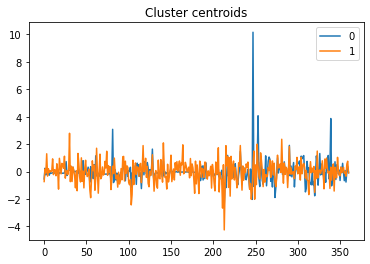

In [54]:
for cluster_number in range (n_clusters):
    plt.plot(ts_kmeans.cluster_centers_[cluster_number, :, 0].T, label = cluster_number)
plt.title("Cluster centroids")
plt.legend()
plt.show()

#Классифицируем наши активы по кластерам

In [55]:
full_ticker_df_2_0['cluster_dtw'] = ts_kmeans.predict(tickers_scaled)
#full_ticker_df_2_0

# Визуализация работы алгоритма базового dtw

Cluster number0
------------------------------------------------------



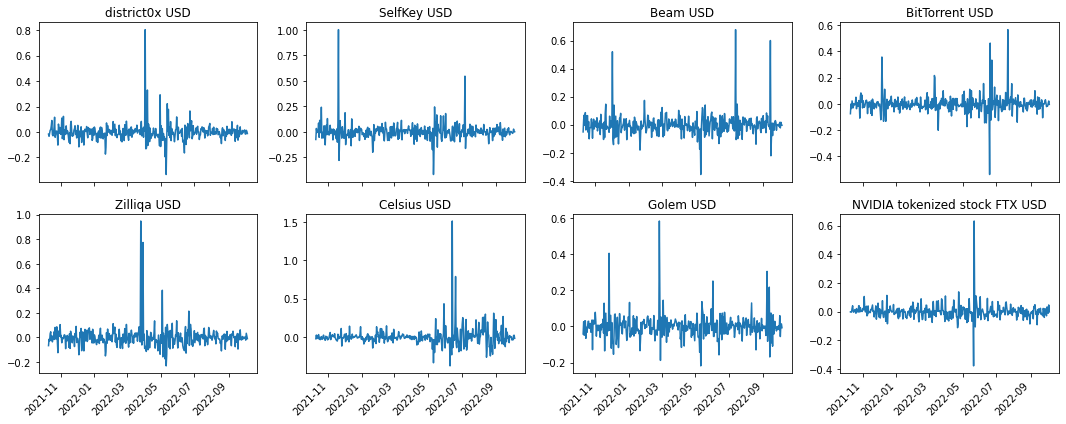

Cluster number1
------------------------------------------------------



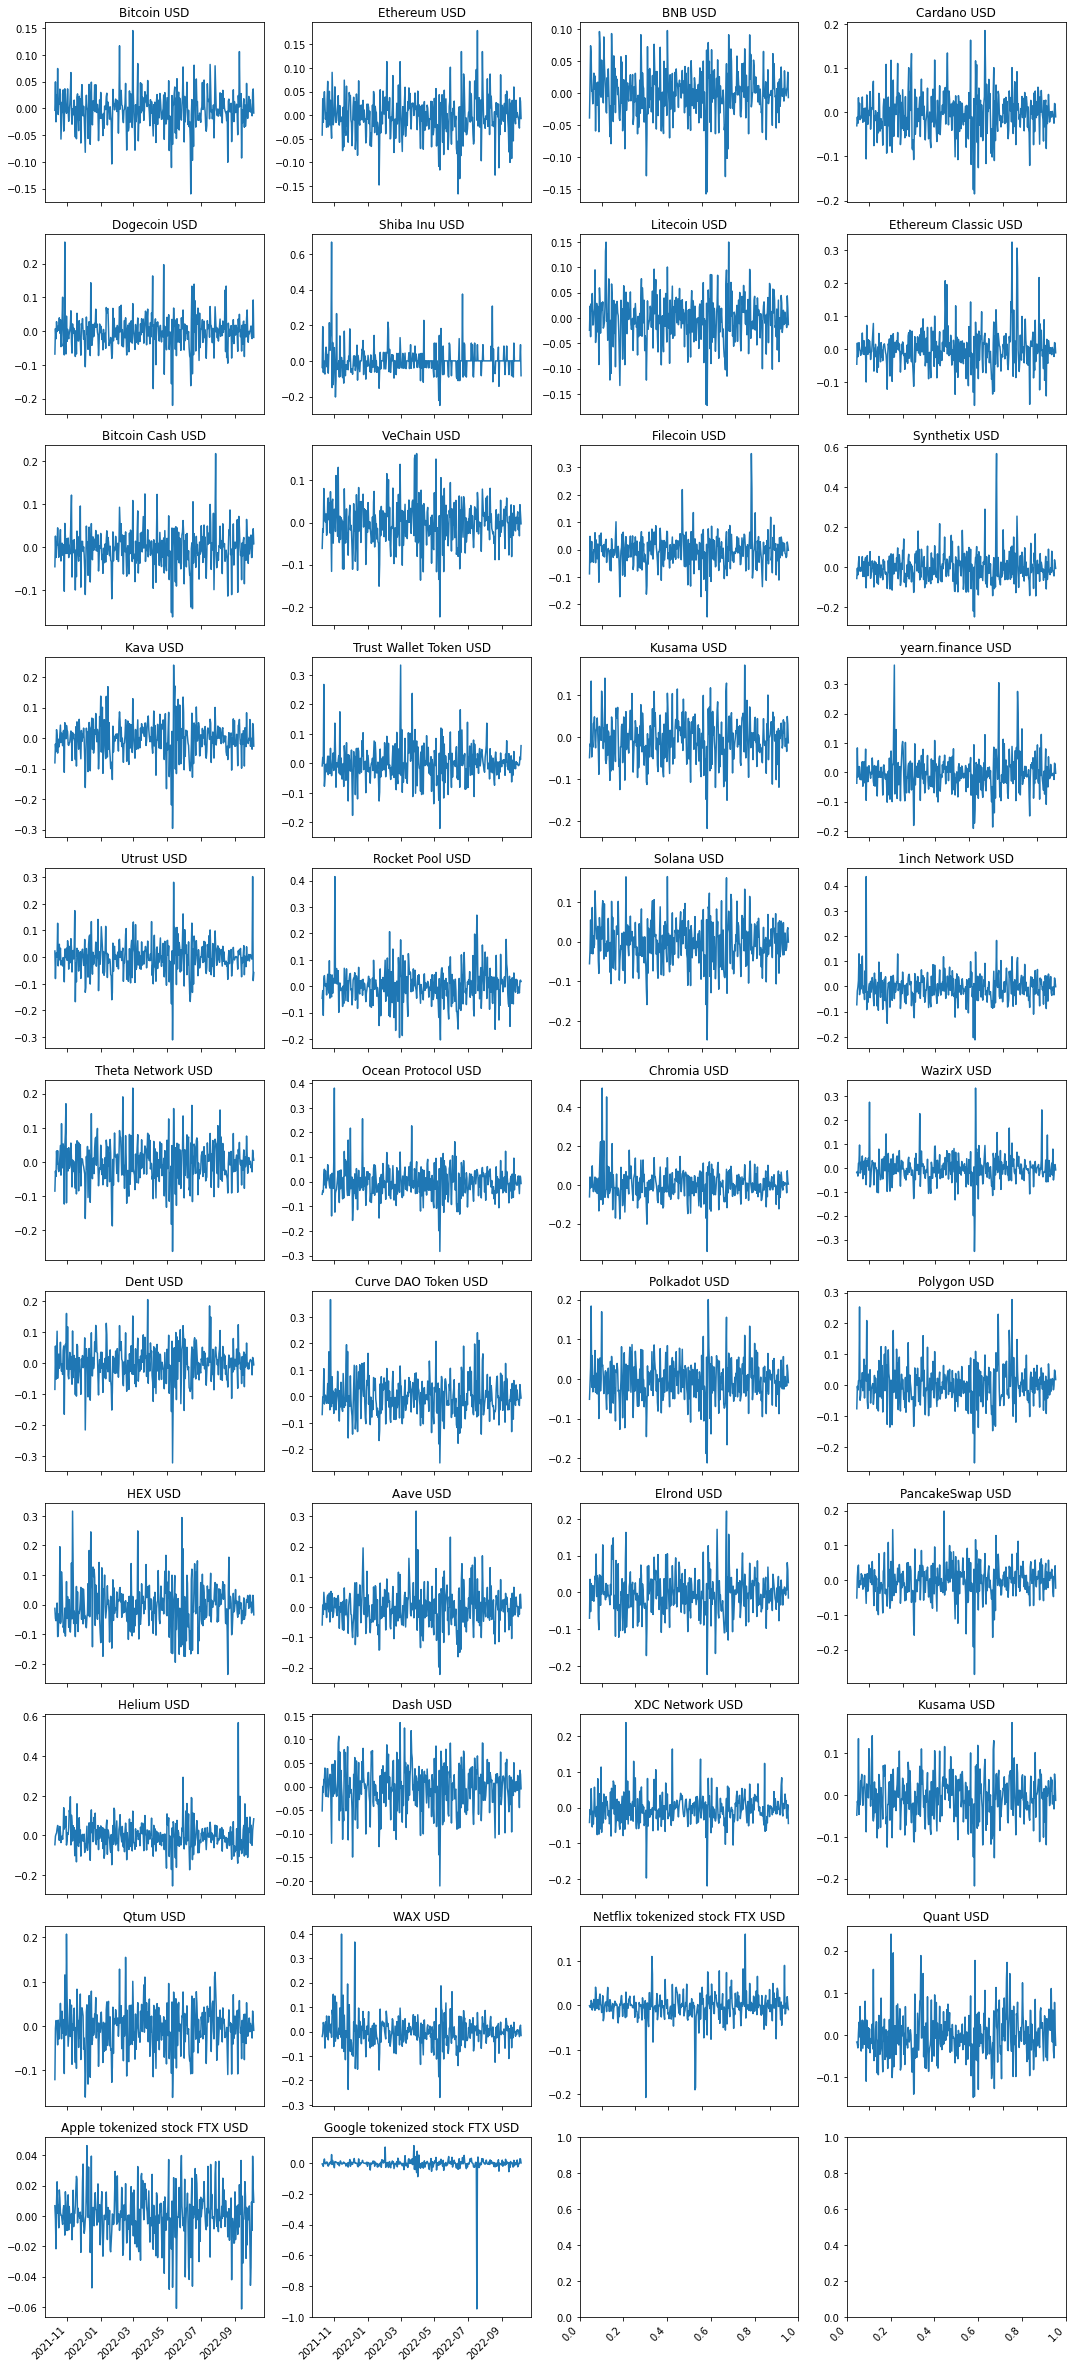

In [56]:
for cluster in range(n_clusters):
    print(f"Cluster number{cluster}")
    print("------------------------------------------------------\n")
    plot_cluster_tickers(full_ticker_df_2_0[full_ticker_df_2_0.cluster_dtw == cluster])

# Иерархический DTW

Для начала построим и обучим нашу модель, в коде ниже используется иерархическое дерево, так как его проще всего и более наглядно можно визуализировать: присудив каждому актив свой кластер

In [57]:
model = clustering.HierarchicalTree(dists_fun=dtw.distance_matrix_fast, dists_options={})
cluster_idx = model.fit(tickers_scaled)

DTAIDistance C-extension for Numpy is not available. Proceeding anyway.
 98%|█████████████████████████████████████████████████████████████████████████████▍ | 49/50 [00:00<00:00, 16328.03it/s]


Визуализируем распределение по кластерам с помощью дендограммы

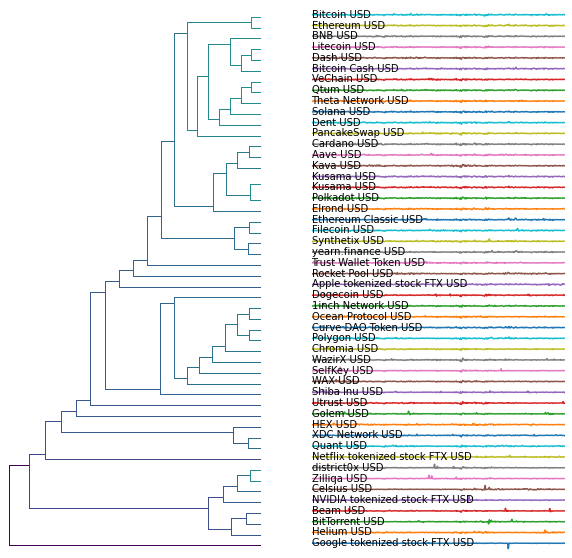

In [59]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
show_ts_label = lambda idx: tickers_scaled_2_df.index[idx]
model.plot(axes=ax, show_ts_label=show_ts_label)
plt.show()

# Итоги

#Хотя базовый метод DTW отработал неплохо, с точки зрения распределения на кластеры: хорошо отделились кластеры с сильными гепами вверх и вниз. Но что касается основного распределения, то 2 кластера, которые нам показал силуэт не являются столь точными, что доказывают графики распределения выше: f.e. как высоко коррелированный Apple может оказаться в одном кластере с наиболее мало коррелированным WAX и etc.
#В данной задаче нам больше подошел бы иерархический дтв, который разбил наши активы более точно (о чем свидетельствует дендограмма выше). Опять таки да, активы распределены не совсем равномерно на 3 кластера, но более точно, чем в базовом dtw.
#Так же стоит отметить, что иерархический DTW справился с задачей кластеризации лучше и чем базовая иерархическая кластеризация (выполненная нами в первой части кода (week_1))

#DTW distance

-это алгоритм, который трансформирует временную шкалу (растягивает или сжимает) с целью достичь оптимального сопоставления или оптимального выравнивания двух последовательностей: ставится задача расположить два временных ряда относительно друг друга таким образом, чтобы расстояние между ними оказалось минимальным.
#Вычисляется след образом:
На первой стадии составляют т.н. матрицу локальных потерь, каждый элемент которой содержит расстояние между парой наблюдений q(i )и r(j). Обычно используют евклидово или манхэттенское расстояния.
На второй стадии находят такой путь трансформации через эту матрицу, который минимизирует суммарное расстояние между рядами Q и R. Это расстояние вычисляется следующим образом: DTW(Q,R)=minϕ(∑(m(ϕ)*l(cm)(k))/M(ϕ)),∀k∈ϕ,
где m(ϕ)>0 — весовой коэффициент, ассоциированный с каждым элементом ϕ, а M(ϕ)— константа, нормализующая длину пути.